In [1]:
import numpy as np 
import speech_recognition as sr
import librosa
import wave
import noisereduce


In [2]:
import speech_recognition as sr

def record_audio(num_records=10):
    recognizer = sr.Recognizer()
    
    for i in range(num_records):
        with sr.Microphone() as source:
            print(f"Recording {i+1}/{num_records}: Speak something:")
            audio = recognizer.listen(source)  # Listen for the phrase
            print("Recognizing...")

            # Save audio to a file with a unique name
            filename = f"recorded_audio_{i+1}.wav"
            with open(filename, "wb") as f:
                f.write(audio.get_wav_data())
            print(f"Saved: {filename}")
    
    return [f"recorded_audio_{i+1}.wav" for i in range(num_records)]

# Call the function to record 10 audio clips
audio_files = record_audio(10)


Recording 1/10: Speak something:
Recognizing...
Saved: recorded_audio_1.wav
Recording 2/10: Speak something:
Recognizing...
Saved: recorded_audio_2.wav
Recording 3/10: Speak something:
Recognizing...
Saved: recorded_audio_3.wav
Recording 4/10: Speak something:
Recognizing...
Saved: recorded_audio_4.wav
Recording 5/10: Speak something:
Recognizing...
Saved: recorded_audio_5.wav
Recording 6/10: Speak something:
Recognizing...
Saved: recorded_audio_6.wav
Recording 7/10: Speak something:
Recognizing...
Saved: recorded_audio_7.wav
Recording 8/10: Speak something:
Recognizing...
Saved: recorded_audio_8.wav
Recording 9/10: Speak something:
Recognizing...
Saved: recorded_audio_9.wav
Recording 10/10: Speak something:
Recognizing...
Saved: recorded_audio_10.wav


here in the first task we record the audio using speech_recognition library that allows us to record the audio from the microphone signals which is in the form of numpy array

In [3]:
import os
# Preprocess the audio files


def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    denoised_audio = noisereduce.reduce_noise(y=audio, sr=sr)
    target_sr = 22050
    resampled_audio = librosa.resample(denoised_audio, orig_sr=sr, target_sr=target_sr)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=resampled_audio, sr=target_sr, n_mfcc=13)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    # Combine MFCCs, delta, and delta-delta
    features = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=0)

    # Normalize
    features = features / (np.max(np.abs(features), axis=0, keepdims=True) + 1e-8)
    mean = np.mean(features.T, axis=0)

    return mean




# Preprocess the audio files
processed_audio_features = []

for file in audio_files:  # Iterate over the recorded audio files directly
    if file.endswith(".wav"):
        print(f"Processing file: {file}")
        features = preprocess_audio(file)
        processed_audio_features.append(features)

# Convert to numpy array for further use
processed_audio_features = np.array(processed_audio_features)

print("Preprocessing completed. Features shape:", processed_audio_features.shape)

Processing file: recorded_audio_1.wav
Processing file: recorded_audio_2.wav
Processing file: recorded_audio_3.wav
Processing file: recorded_audio_4.wav
Processing file: recorded_audio_5.wav
Processing file: recorded_audio_6.wav
Processing file: recorded_audio_7.wav
Processing file: recorded_audio_8.wav
Processing file: recorded_audio_9.wav
Processing file: recorded_audio_10.wav
Preprocessing completed. Features shape: (10, 39)


mfcc features also known to be as Mel -frequency cepstal coefficients are set of features like chroma or spectral
they are coefficients features that captures the shape of the features which basically derived by transforming the raw audio signal into frequency domain similar to DFT
they emphasize features of the audio signal that are important for human speech perception while discarding less relevant information. This makes them effective for tasks like speaker recognition, emotion detection, and speech-to-text conversion.
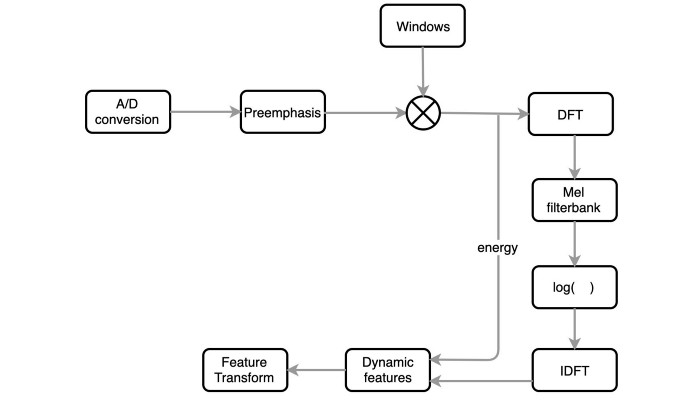

these features are calculated by seven step process
1. Pre-emphasis: This step involves applying a high-pass filter to the audio signal to boost 
the high-frequency components. This is done to give more importance to the high-frequency components of the speech
2. Framing: The audio signal is divided into small frames of 20-30 milliseconds each
3. Windowing: A window function is applied to each frame to reduce the discontinuities at
the start and end of the frame
4. Fourier Transform: The windowed frame is then transformed into the frequency domain using the Fast Fourier
Transform (FFT)
5. Filtering: The frequency components are then filtered to remove the unimportant components
MEL f=1125*ln(1+f/700)
6. Logarithmic Scaling: The filtered frequency components are then scaled using the logarithmic function to
compress the dynamic range of the signal
7. Discrete Cosine Transform (DCT): The log-scaled frequency components are then transformed
into the cepstral domain using the DCT





In [4]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


# Normalize data (this step is critical for MFCCs)
scaler = StandardScaler()
X_train = scaler.fit_transform(processed_audio_features)


def build_model(input_shape):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(input_shape, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 Regularization
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes
    ])

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# # Convert to numpy array for training
# X_train = np.array(processed_audio_features)  # Shape (num_samples, 13)
# y_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  



# Build the model
model = build_model(X_train.shape[1])  # Input shape is 13 for MFCC features

# # Fit the model (this would typically be on a larger dataset)
# model.fit(X_train, y_train, epochs=50)

c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Here after preprocessing the 10 recorded audio signals we build the CNN model where the model layers are stacked one after other i.e sequential 

the input layers are are conv1D with 256 filters capturing the Mel frequency cepstral coefficients over time
the activation function used is ReLU to introduce non linearity in the model
the pooling layer is max pooling with a pool size of 2 to reduce the spatial dimensions of the feature that is mapped 
the flatten converts the 3d tensors to 1D vectors



In [5]:
from sklearn.model_selection import train_test_split
def train_model():
    # Convert to numpy array for training
    X_train = np.array(processed_audio_features)  # Shape (num_samples, 13)
    y_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  

   # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Build the model
    model = build_model(X_train.shape[1])
    
    # Train the model (fit on a larger dataset in practice)
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    
    return model

# Train the model
model = train_model()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1250 - loss: 4.6272
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1250 - loss: 4.0818
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3750 - loss: 3.7229
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2500 - loss: 3.4487
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5000 - loss: 3.2108
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8750 - loss: 2.9920
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8750 - loss: 2.9137
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 2.8246
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8750 - loss: 2.5225
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 2.4867


In [7]:
def preprocess_audio_files(audio_files):
    processed_audio_features = []
    for file in audio_files:
        if file.endswith(".wav"):
            print(f"Processing file: {file}")
            features = preprocess_audio(file)
            processed_audio_features.append(features)
    return np.array(processed_audio_features)



def recognize_speech_from_audio(audio_files):
    recognizer = sr.Recognizer()
    
    for file in audio_files:
        with sr.AudioFile(file) as source:
            print(f"Recognizing speech from {file}...")
            audio = recognizer.record(source)  # Read the entire audio file
            
            try:
                # Use Google's Speech Recognition to convert audio to text
                text = recognizer.recognize_google(audio)
                print(f"Text recognized: {text}")
            except sr.UnknownValueError:
                print("Could not understand audio.")
            except sr.RequestError as e:
                print(f"Could not request results from Google Speech Recognition service; {e}")

# Step 7: Run the full pipeline
audio_files = record_audio(10)  # Record 10 audio clips
processed_audio_features = preprocess_audio_files(audio_files)  # Preprocess the audio files

# Recognize the recorded speech as text
recognize_speech_from_audio(audio_files)

Recording 1/10: Speak something:
Recognizing...
Saved: recorded_audio_1.wav
Recording 2/10: Speak something:
Recognizing...
Saved: recorded_audio_2.wav
Recording 3/10: Speak something:
Recognizing...
Saved: recorded_audio_3.wav
Recording 4/10: Speak something:
Recognizing...
Saved: recorded_audio_4.wav
Recording 5/10: Speak something:
Recognizing...
Saved: recorded_audio_5.wav
Recording 6/10: Speak something:
Recognizing...
Saved: recorded_audio_6.wav
Recording 7/10: Speak something:
Recognizing...
Saved: recorded_audio_7.wav
Recording 8/10: Speak something:
Recognizing...
Saved: recorded_audio_8.wav
Recording 9/10: Speak something:
Recognizing...
Saved: recorded_audio_9.wav
Recording 10/10: Speak something:
Recognizing...
Saved: recorded_audio_10.wav
Processing file: recorded_audio_1.wav
Processing file: recorded_audio_2.wav
Processing file: recorded_audio_3.wav
Processing file: recorded_audio_4.wav
Processing file: recorded_audio_5.wav
Processing file: recorded_audio_6.wav
Processing